In [1]:
library('ggplot2')
library('dplyr')
library("plot3D")

Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.2.2"

Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"pakiet 'plot3D' został zbudowany w wersji R 4.2.2"


In [2]:
data_wind <- read.csv('wind_clouds.csv')
colnames(data_wind) <- c('time','clouds','sun', 'speed', 'direction')

In [85]:
find_category <- function(speed, sun, clouds){
    if(speed<2){
        if(sun>=280) p<-'A'
        else if(sun>=120) p<-'B'
        else if(clouds>=50) p<-'E'
        else p<-'F'
    }
    else if(speed<3){
        if(sun>=479) p<-'A'
        else if(sun>=280) p<-'B'
        else if(sun>=120) p<-'C'
        else if(clouds>=50) p<-'E'
        else p<-'F'
    }
    else if(speed<5){
        if(sun>=280) p<-'B'
        else if(sun>=120) p<-'C'
        else if(clouds>=50) p<-'D'
        else p<-'E'
    }
    else if(speed<6){
        if(sun>=280) p<-'C'
        else p<-'D'
    }
    else{
        if(sun>=479) p<-'C'
        else p<-'D'
    }
    return(p)
}

In [86]:
find_p <- function(category){
    if(category=='A'|category=='B') p <- .15
    else if(category=='C') p <- .2
    else if(category=='D') p <- .25
    else p <- .3
    return(p)
}

In [87]:
find_a_b <- function(x,category){
    if(category=='A'){
        if(x<.1) pars <- c(122.800,0.94470)
        else if(x<.15) pars <- c(158.080,1.05420)
        else if(x<.2) pars <- c(170.220,1.09320)
        else if(x<.25) pars <- c(179.520,1.12620)
        else if(x<.3) pars <- c(217.410,1.26440)
        else if(x<.4) pars <- c(258.890,1.40940)
        else if(x<.5) pars <- c(346.750,1.72830)
        else if(x<=3.11) pars <- c(453.850,2.11660)
        else pars <- c(5000,1)
    }
    else if(category=='B'){
        if(x<.2) pars <- c(90.673,0.93198)
        else if(x<.4) pars <- c(98.483,0.98332)
        else pars <- c(109.300,1.09710)
    }
    else if(category=='C') pars <- c(61.141,0.91465)
    else if(category=='D'){
        if(x<.3) pars <- c(34.459,0.86974)
        else if(x<1) pars <- c(32.093,0.81066)
        else if(x<3) pars <- c(32.093,0.64403)
        else if(x<10) pars <- c(33.504,0.60486)
        else if(x<30) pars <- c(36.650,0.56589)
        else pars <- c(44.053,0.51179)
    }
    else if(category=='E'){
        if(x<.1) pars <- c(24.260,0.83660)
        else if(x<.3) pars <- c(23.331,0.81956)
        else if(x<1) pars <- c(21.628,0.75660)
        else if(x<2) pars <- c(21.628,0.63077)
        else if(x<4) pars <- c(22.534,0.57154)
        else if(x<10) pars <- c(24.703,0.50527)
        else if(x<20) pars <- c(26.970,0.46713)
        else if(x<40) pars <- c(35.420,0.37615)
        else pars <- c(47.618,0.29592)
    }
    else{
        if(x<.2) pars <- c(15.209,0.81558)
        else if(x<.7) pars <- c(14.457,0.78407)
        else if(x<1) pars <- c(13.953,0.68465)
        else if(x<2) pars <- c(13.953,0.63227)
        else if(x<3) pars <- c(14.823,0.54503)
        else if(x<7) pars <- c(16.187,0.46490)
        else if(x<15) pars <- c(17.836,0.41507)
        else if(x<30) pars <- c(22.651,0.32681)
        else if(x<60) pars <- c(27.074,0.27436)
        else pars <- c(34.219,0.21716)
    }
    return(pars)
}

In [88]:
find_theta <- function(x,category){
    if(category=='A') pars <- c(24.1670,2.5334)
    else if(category=='B') pars <- c(18.3330,1.8096)
    else if(category=='C') pars <- c(12.5000,1.0857)
    else if(category=='D') pars <- c(8.3330,0.72382)
    else if(category=='E') pars <- c(6.2500,0.54287)
    else pars <- c(4.1667,0.36191)
    theta <- .017453293*(pars[1]-pars[2]*log(x))
    return(theta)
}

In [89]:
get_concentration <- function(Q,u,h,dy,dz,y,z){
    result = Q/(2*pi*u*dy*dz)*(exp(-(z-h)^2/(2*dz^2))+exp(-(z-h)^2/(2*dz^2)))*exp(-y^2/(2*dy^2))
    return(result)
}

In [90]:
gaussian_plume_xyh <- function(row,y,z, h=10, x_vec=seq(.1,10,.01), Q=10){
    category <- find_category(row$speed,row$sun,row$clouds)
    p <- find_p(category)
    cs <- c()
    for(x in x_vec){
        if(x<=0){
            cs <- c(cs,0)
            next
        }
        a_b <- find_a_b(x,category)
        theta <- find_theta(x,category)
        u <- row$speed*(h/10)^p
        a <- a_b[1]
        b <- a_b[2]
        dz <- a*x**b
        if(dz>5000) dz<-5000
        dy <- 465.11628*x*tan(theta)
        c1 <- get_concentration(Q,u,h,dy,dz,y,z)
        cs <- c(cs,c1)
    }
    return(cs)
}

In [91]:
pollution_average2 <- function(en,r,c){
    new_matrix <- matrix(data=0, nrow=r, ncol=c)
    new_matrix[1,1] = mean(c(en[1,1],en[2,1],en[1,2],0,0))
    new_matrix[1,c] = mean(c(en[1,c],en[2,c],en[1,(c-1)],0,0))
    new_matrix[r,1] = mean(c(en[r,1],en[(r-1),1],en[r,2],0,0))
    new_matrix[r,c] = mean(c(en[r,c],en[(r-1),c],en[r,(c-1)],0,0))
    for(i in 2:(r-1)) new_matrix[i,1] = mean(c(en[i,1],en[i-1,1],en[i+1,1],en[i,2],0))
    for(i in 2:(r-1)) new_matrix[i,c] = mean(c(en[i,c],en[i-1,c],en[i+1,c],en[i,(c-1)],0))
    for(j in 2:(c-1)) new_matrix[1,j] = mean(c(en[1,j-1],en[1,j],en[1,j+1],en[2,c],0))
    for(j in 2:(c-1)) new_matrix[r,j] = mean(c(en[r,j-1],en[r,j],en[r,j+1],en[(r-1),j],0))
    for(i in 2:(r-1)){
        for(j in 2:(c-1)) new_matrix[i,j] = mean(c(en[i,j],en[i-1,j],en[i+1,j],en[i,j-1],en[i,j+1]))
    }
    return(new_matrix)
}

In [92]:
plume_time_gen <- function(t,base,h,sx,sy,z){
    nx <- length(sx)
    ny <- length(sy)
    nt <- nx*ny
    y_base <- c()
    for(i in sy) y_base <- c(y_base,rep(i,nx))
    old <- data.frame(y_base,rep(sx,ny),rep(0,nt))
    colnames(old) <- c('y','x','cs')
    old <- old %>% group_by(y,x)
    for(j in t){
        row <- base[j,]
        angle <- row$direction*2*pi/360
        cond <- data.frame()
        for(i in sy){
            temp <- gaussian_plume_xyh(row,i,z,h=h,x_vec=sx)
            df_temp <- data.frame(rep(i,nx),sx,temp)
            colnames(df_temp) <- c('y','x','cs')
            cond <- rbind(cond,df_temp)
        }
        old_temp <- t(matrix(old$cs,nrow=nx,ncol=ny))
        new_base <- pollution_average2(old_temp,ny,nx)
        new <- c()
        for(i in 1:(dim(new_base)[1])) new <- c(new,new_base[i,])
        old$cs <- new
        cond$x <- round(cond$x*cos(angle)-cond$y*sin(angle),2)
        cond$y <- round(cond$y*cos(angle)+cond$x*sin(angle),2)
        cond <- cond[cond$y %in% sy,]
        cond <- cond[cond$x %in% sx,]
        cond <- cond %>% group_by(y,x) %>% summarise(cs=mean(cs))
        old <- rbind(old,cond)
        old <- old %>% group_by(y,x) %>% summarise(cs=sum(cs))
    }
    return(old)
}

In [47]:
m3 <- plume_time_gen(c(3),data_wind,10,seq(0.001,0.15,0.001),seq(-10,10,.01),11)

`summarise()` has grouped output by 'y'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'y'. You can override using the `.groups` argument.


In [83]:
max(m3$cs)

ERROR: Error in eval(expr, envir, enclos): nie znaleziono obiektu 'm3'


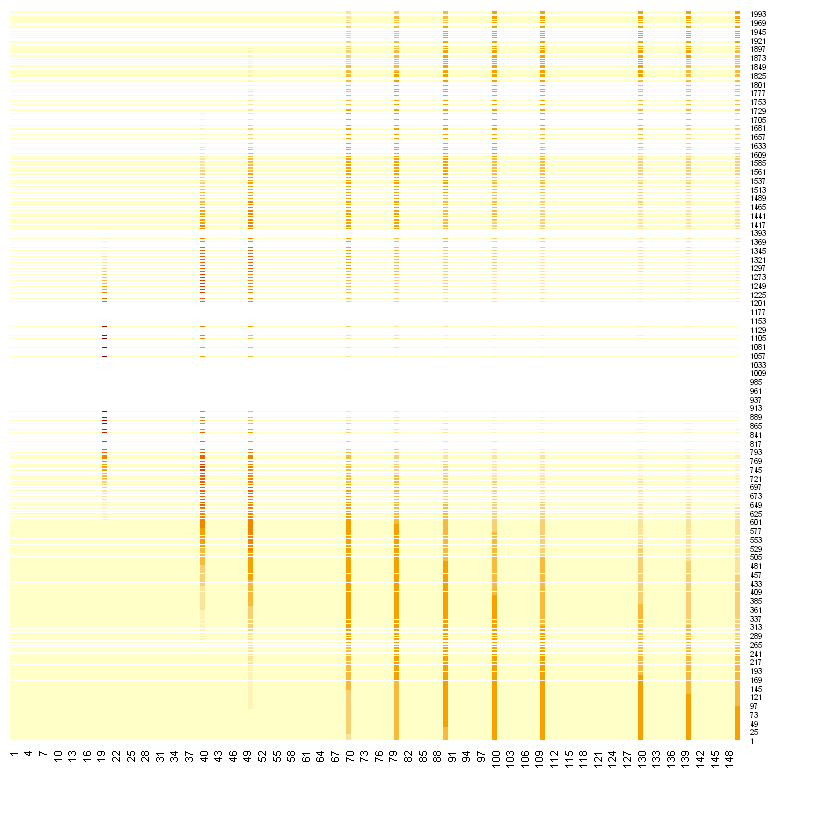

In [48]:
heatmap(t(matrix(m3$cs,nrow=150,ncol=2001)), Rowv = NA, Colv = NA)

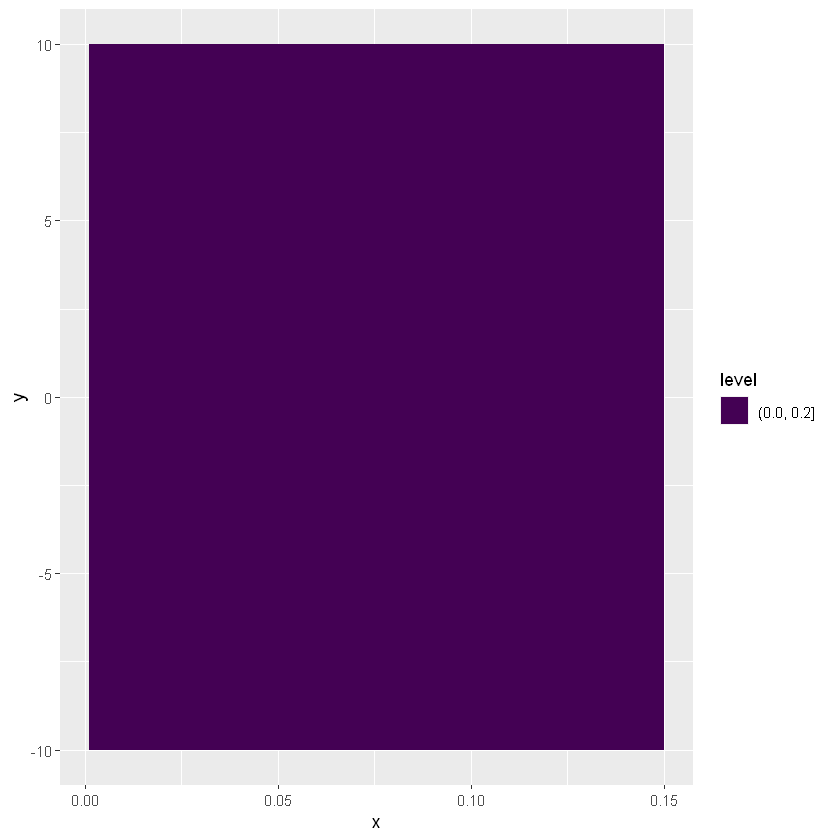

In [26]:
ggplot(m1, aes(x,y,z=cs))+geom_contour_filled(breaks=c(0,0.001,0.01,0.1,0.5,1,max(m1$cs)))

In [101]:
y1 <- c()
cond1 <- c()
sx <- seq(0.01,1,0.01)
nx <- length(sx)
sy <- seq(-10,10,.01)
ny <- length(sy)
nt <- nx*ny
base <- data_wind[300,]
for(i in sy){
    y1 <- c(y1,rep(i,nx))
    cond1 <- c(cond1,gaussian_plume_xyh(base,i,0,h=10,x_vec=sx))
}

In [102]:
max(cond1)

[1] 0.0024742

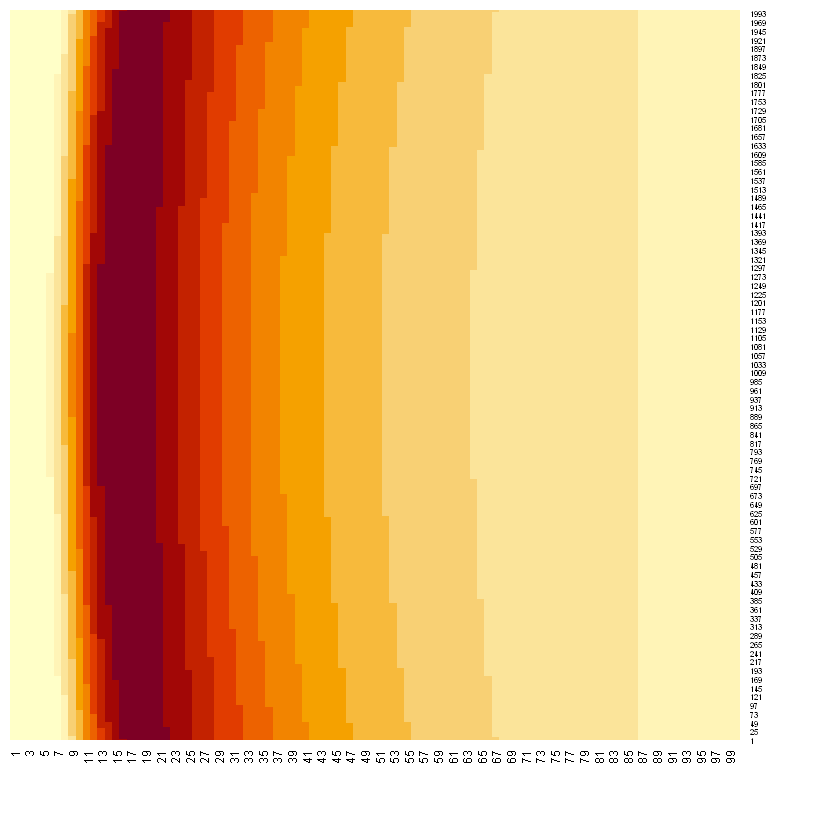

In [103]:
heatmap(t(matrix(cond1,nrow=100,ncol=2001)), Rowv = NA, Colv = NA)

https://en.wikipedia.org/wiki/Rotation_of_axes

In [123]:
y2 <- c()
cond2 <- c()
sx <- seq(0.01,2.01,0.01)
sy <- seq(-10,10,.01)
nx <- length(sx)
ny <- length(sy)
base <- data_wind[3,]
for(i in sy){
    y2 <- c(y2,rep(i,nx))
    cond2 <- c(cond2,gaussian_plume_xyh(base,i,1.7,h=10,x_vec=sx))
}

In [12]:
t1 <- seq(0.0001,0.2001,0.0001)
t2 <- seq(-10,10,.01)
t3 <- round(t1*cos(pi/6)+t2*sin(pi/6),4)
t4 <- round(t2*cos(pi/6)-t1*sin(pi/6),4)
t5 <- round(t3*cos(pi/6)-t4*sin(pi/6),4)
t6 <- round(t4*cos(pi/6)+t3*sin(pi/6),2)

In [124]:
df2 <- data.frame(y2,rep(sx,ny),cond2)
colnames(df2) <- c('y','x','cs')
df2 <- df2 %>% group_by(y,x) %>% summarise(cs=mean(cs))
df2$x <- round(df2$x*cos(pi/6)-df2$y*sin(pi/6),2)
df2$y <- round(df2$y*cos(pi/6)+df2$x*sin(pi/6),2)
df2_2 <- df2[df2$x %in% sx & df2$y %in% sy,]

`summarise()` has grouped output by 'y'. You can override using the `.groups` argument.


In [125]:
df3 <- data.frame(y2,rep(sx,ny),cond2)
colnames(df3) <- c('y','x','cs')
df3 <- df3 %>% group_by(y,x) %>% summarise(cs=mean(cs))

`summarise()` has grouped output by 'y'. You can override using the `.groups` argument.


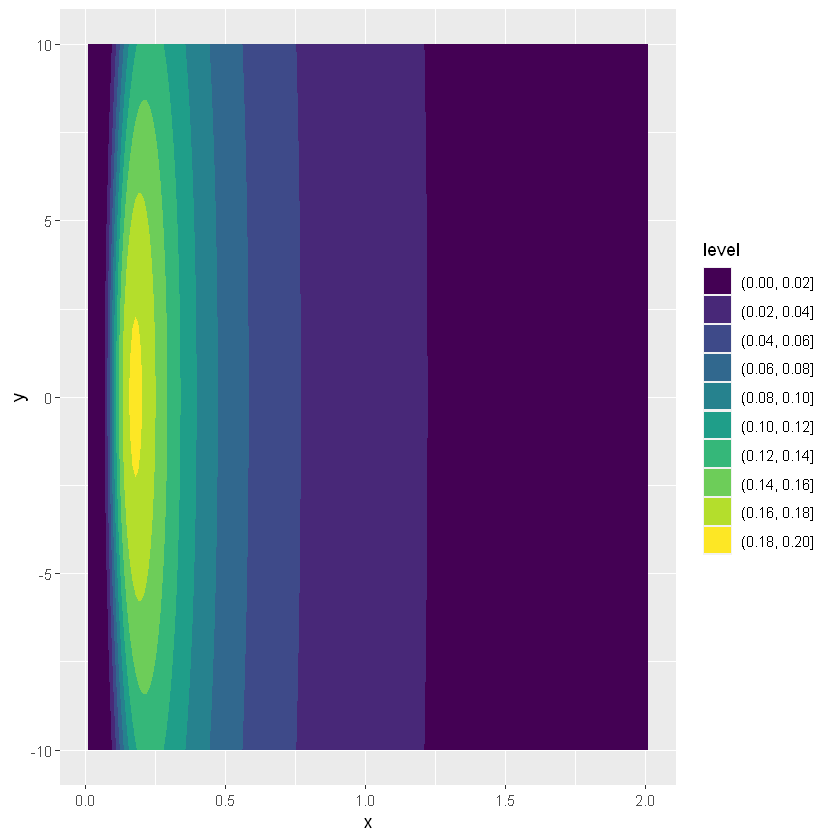

In [126]:
ggplot(df3, aes(x,y,z=cs))+geom_contour_filled()

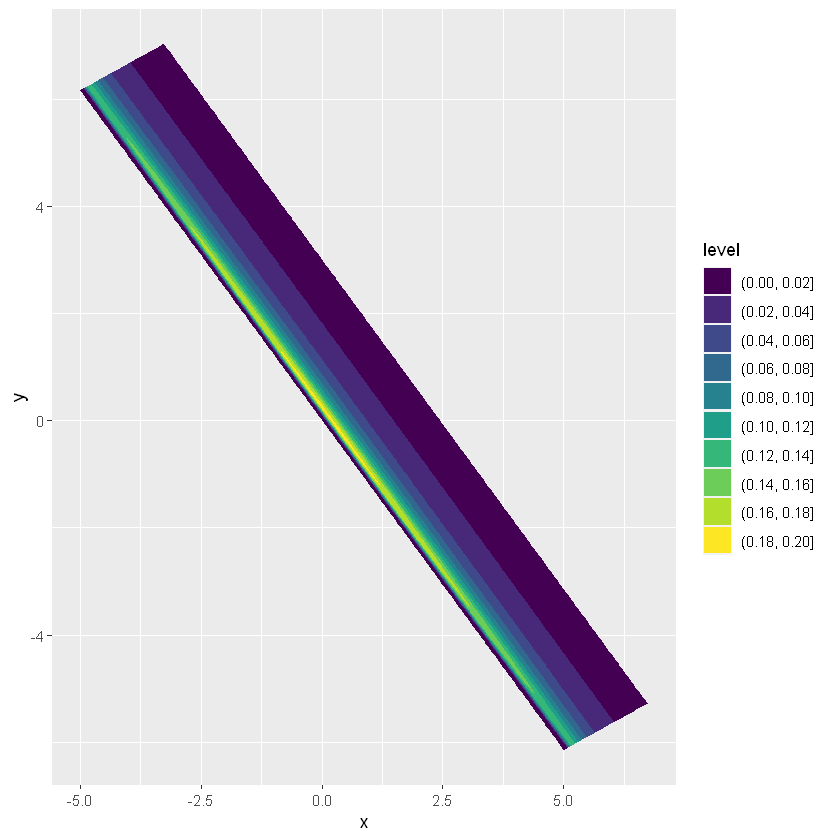

In [127]:
ggplot(df2, aes(x,y,z=cs))+geom_contour_filled()

In [128]:
base1 <- t(matrix(0,nrow=201,ncol=2001))
df2 <- df2[df2$x>0&df2$x<=0.21,]
for(j in 1:length(df2$y)){
    temp <- df2[j,]
    base1[as.integer(temp$y*100+1001),as.integer(temp$x*100)] <- temp$cs
}

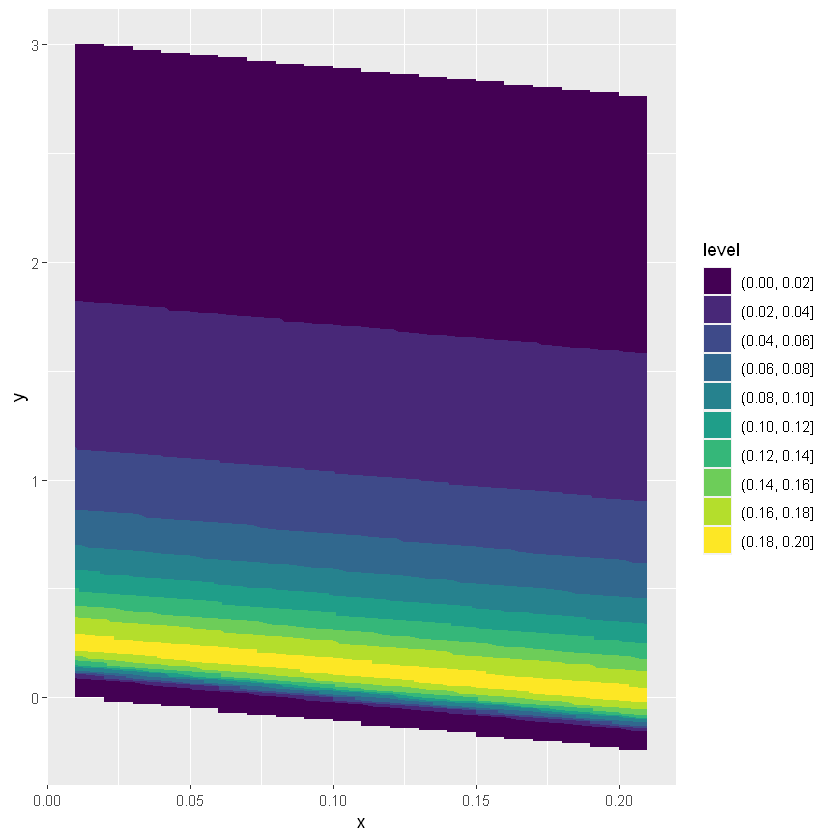

In [129]:
ggplot(df2, aes(x,y,z=cs))+geom_contour_filled()

In [130]:
base2 <- base1+t(matrix(df3$cs,nrow=201,ncol=2001))

In [131]:
df5 <- data.frame(df3$y,df3$x,c(base2))
colnames(df5) <- c('y','x','cs')

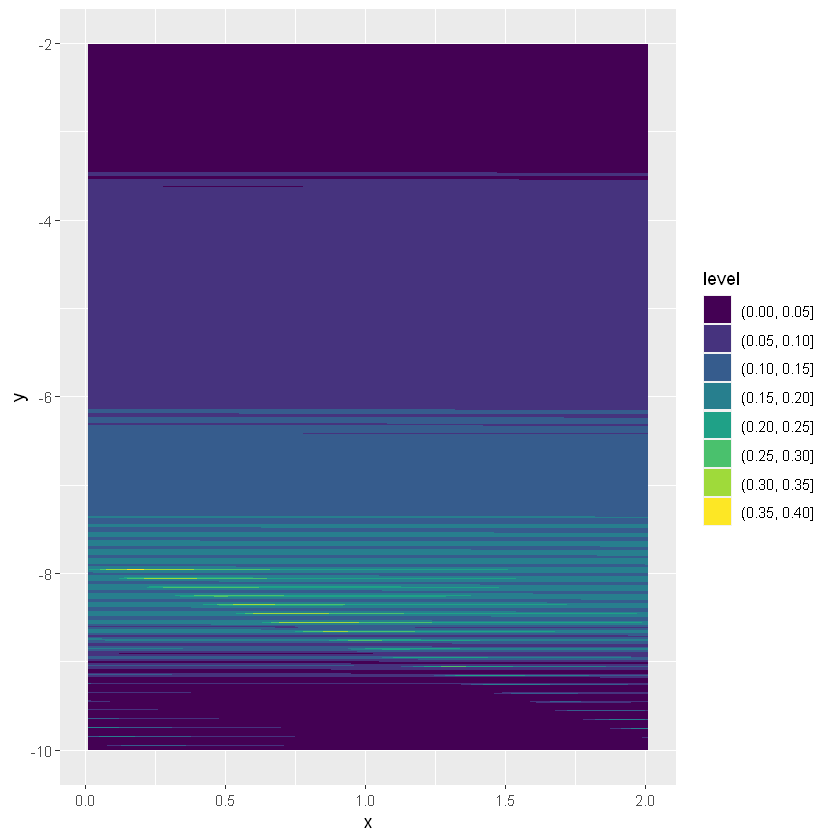

In [134]:
ggplot(df5[df5$y<(-2),], aes(x,y,z=cs))+geom_contour_filled()

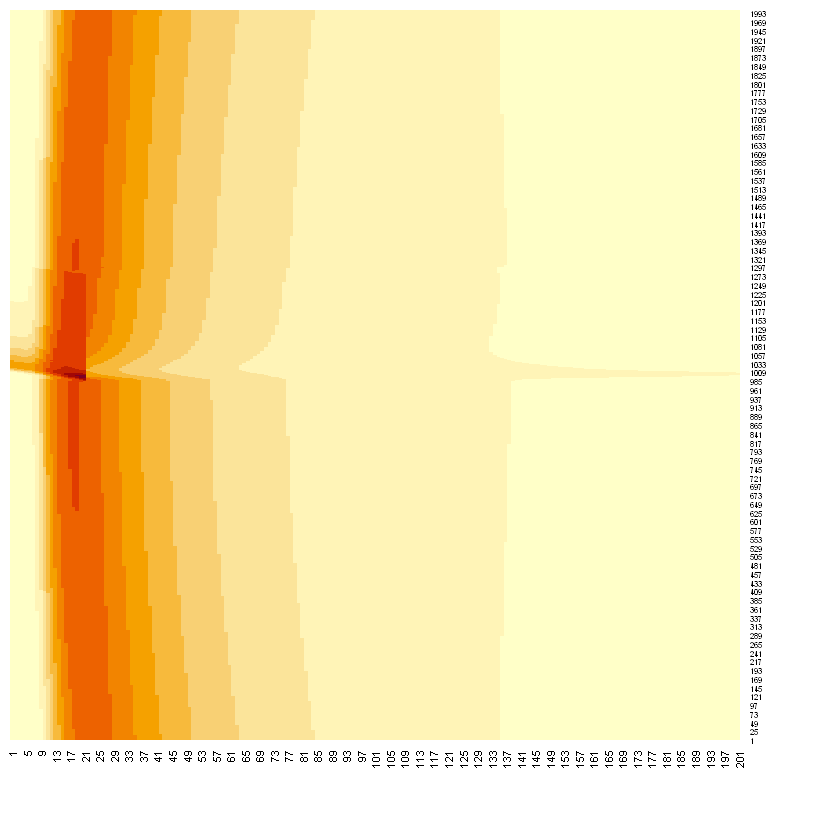

In [133]:
heatmap(base2, Rowv = NA, Colv = NA)